# 509 Final Project

The notebook is for Exploratory Data Analysis (EDA), text data preprocessing, modeling, and evaluation.

## Globally import libraries

In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import datetime as dt
import emoji
import itertools
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymysql as mysql
import random
import re
import regex as rex
import requests
import shutil
from string import punctuation
import time
from tqdm import tqdm
import zipfile

import nltk
from nltk.corpus import stopwords
import spacy

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.feature_extraction.text import TfidfTransformer, \
CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.metrics import make_scorer, f1_score, classification_report, \
confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import textacy.preprocessing as tprep
from textacy.extract import keyword_in_context

# Set pandas global options
pd.options.display.max_rows = 17
pd.options.display.precision = 4
np.set_printoptions(suppress=True, precision=4)

%matplotlib inline

## Upload data from CSV

In [2]:
'''Dir nav citation:
https://softhints.com/python-change-directory-parent/'''
curr_dir = os.path.abspath(os.curdir)
print(curr_dir)
os.chdir("..")
up1_dir = os.path.abspath(os.curdir)
print(up1_dir)

C:\Users\acarr\Documents\GitHub\ADS509_Final_project\deliverables
C:\Users\acarr\Documents\GitHub\ADS509_Final_project


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = 'data'

file_in_name01 = 'master.csv'
file_in_name02 = 'master_business_TheHill.csv'

file_in_path01 = os.path.join(up1_dir, data_location, file_in_name01)
file_in_path02 = os.path.join(curr_dir, file_in_name02)

print(f'CSV file 1 in path: {file_in_path01}')
print(f'CSV file 2 in path: {file_in_path02}')

CSV file 1 in path: C:\Users\acarr\Documents\GitHub\ADS509_Final_project\data\master.csv
CSV file 2 in path: C:\Users\acarr\Documents\GitHub\ADS509_Final_project\deliverables\master_business_TheHill.csv


### Review dataframe

In [4]:
slct_tbl_full_df01 = pd.read_csv(file_in_path01)
print(f'Dataframe shape: {slct_tbl_full_df01.shape}')
display(slct_tbl_full_df01.head())

Dataframe shape: (4509, 7)


,source_name,author,title,url,publish_date,content,article_text
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic..."
4,The Washington Post,NaN,The revolt of Christian home-schoolers...,https://www.washingtonpost.com/education/inter...,2023-05-30T18:25:37Z,Deep Reads features The Washington Posts best ...,NaN


## Exploratory Data Analysis (EDA)

### Count missing `article_text` feature

The majority of null values appear in the `content` column. There are also several in `author` and one in `article_text`. Neither `content` nor `author` will be used for current modeling efforts, therefore they are not a factor. The one instance with missing article text will be removed.

In [5]:
count_nan = slct_tbl_full_df01.isnull().sum()
 
# printing the number of values present
# in the column
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: source_name        0
author            37
title              0
url                0
publish_date       0
content         3351
article_text       1
dtype: int64


### Count blank `article_text` feature

In [6]:
print(len(slct_tbl_full_df01[slct_tbl_full_df01['article_text']=='']))
display(slct_tbl_full_df01[slct_tbl_full_df01['article_text']==''].head(20))

0


,source_name,author,title,url,publish_date,content,article_text


### Remove missing `article_text` row(s)

In [7]:
'''Drop missing citation:
https://pandas.pydata.org/pandas-docs/stable/reference
/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna'''
slct_tbl_full_df02 = slct_tbl_full_df01.dropna(subset=['article_text'])
print(f'Dataframe shape: {slct_tbl_full_df02.shape}')
display(slct_tbl_full_df02.head())

Dataframe shape: (4508, 7)


,source_name,author,title,url,publish_date,content,article_text
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic..."
5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron..."


### Count characters and words for initial review

In [8]:
tqdm.pandas(ncols=50)  # can use tqdm_gui, optional kwargs, etc
# Now you can use `progress_apply` instead of `apply`

# Raw text character and word counts
slct_tbl_full_df02['char_cnt'] = slct_tbl_full_df02['article_text']\
.progress_apply(len)
slct_tbl_full_df02['word_cnt'] = slct_tbl_full_df02['article_text']\
.progress_apply(lambda x: len(x.split()))
display(slct_tbl_full_df02.head())

100%|█████| 4508/4508 [00:00<00:00, 361507.42it/s]
C:\Users\acarr\AppData\Local\Temp\ipykernel_21248\2936833956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_tbl_full_df02['char_cnt'] = slct_tbl_full_df02['article_text']\
100%|██████| 4508/4508 [00:00<00:00, 18630.51it/s]
C:\Users\acarr\AppData\Local\Temp\ipykernel_21248\2936833956.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_tbl_full_df02['word_cnt'] = slct_tbl_full_df02['article_text']\


,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955
5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750


### Descriptive statistics

Stats are displayed for both categorical and numerical columns. As expected "Fox News" is the most frequent value in `source_name` as the most articles were collected from that news site. The inclusion of "Associated Press" as the mode for `author` identified it as a potential source for skew in the final results, as AP was rated as a "center" source in the AllSide Media Bias Chart. As a result, all articles with an `author` value of "Associated Press" were removed; similarily, articles by "msn" and "Reuters" were also removed. \
For the numerical values, there was a very large range for both character and word counts (80,454 and 14,306, respectively), but also a large delta between the 75% percentile and max (74,920.5 and 13,433, respectively), indicating a distribution with a very long right tail with a very small amount of some extremely long (outlier) articles. As a result, the standard deviation was also quite large relative to the mean. For the current analyses, no additional efforts will be performed to account for outliers, but this will be an examination factor for future expansion/comparative studies.

In [9]:
slct_tbl_full_df02[['source_name',
                    'author',
                    'publish_date',
                    'article_text']].describe(include="O").T

,count,unique,top,freq
source_name,4508,4,Fox News,2192
author,4472,956,Associated Press,450
publish_date,4508,4486,2023-05-13T11:00:00Z,3
article_text,4508,4508,Travelers in Alabama driving on Interstate 65 ...,1


In [10]:
slct_tbl_full_df02.describe().T

,count,mean,std,min,25%,50%,75%,max
char_cnt,4508.0,4655.5011,3137.3650,131.0,2832.0,3951.5,5664.5,80585.0
word_cnt,4508.0,731.0315,518.5765,16.0,432.0,607.0,889.0,14322.0


### Display Source counts

In [11]:
slct_tbl_full_df02['source_name'].value_counts()

Fox News               2192
Breitbart News         1017
CNN                     773
The Washington Post     526
Name: source_name, dtype: int64

### Examine inclusion of "centrist" sources indicated by `author` feature

In [12]:
slct_tbl_full_df02a = slct_tbl_full_df02[slct_tbl_full_df02['author']\
                                         .isin(['msn',
                                                'Associated Press',
                                                'Reuters'])]

display(slct_tbl_full_df02a[slct_tbl_full_df02a['author']=='msn'])

display(slct_tbl_full_df02a.groupby(by=['source_name', 'author']).count())

,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt
17,The Washington Post,msn,State Dept seeks to expand space diplomacy...,https://www.washingtonpost.com/technology/2023...,2023-05-30T17:00:04Z,State Department seeks to expand its space dip...,"With tensions rising in space, low Earth orbit...",6249,1008
18,The Washington Post,msn,SHOCK IN RUSSIAN CAPITAL,https://www.washingtonpost.com/world/2023/05/3...,2023-05-30T13:00:04Z,"KYIV, Ukraine A drone attack hit Moscow on Tue...","KYIV, Ukraine — A drone attack hit Moscow on T...",8700,1395
22,The Washington Post,msn,Debate over whether AI will destroy us is divi...,https://www.washingtonpost.com/technology/2023...,2023-05-20T21:00:04Z,The debate over whether AI will destroy us is ...,"At a congressional hearing this week, OpenAI C...",11197,1818
81,The Washington Post,msn,Corporate bankruptcies creeping up as pressure...,https://www.washingtonpost.com/business/2023/0...,2023-05-23T12:00:04Z,Corporate bankruptcies are creeping up as pres...,Corporate bankruptcies are edging back up afte...,5115,802
84,The Washington Post,msn,The looming existential crisis for cable news...,https://www.washingtonpost.com/media/2023/05/2...,2023-05-23T14:00:04Z,The looming existential crisis for cable news ...,"After a week of promotion and controversy, CNN...",7136,1154
...,...,...,...,...,...,...,...,...,...
492,The Washington Post,msn,Biden shows growing appetite to cross Putin's ...,https://www.washingtonpost.com/national-securi...,2023-06-01T11:00:04Z,President Bidens decision last month to help U...,President Biden’s decision last month to help ...,9676,1533
502,The Washington Post,msn,Behind-the-scenes videos of Tucker Carlson wer...,https://www.washingtonpost.com/media/2023/06/0...,2023-06-02T02:00:03Z,Behind-the-scenes videos of Tucker Carlson wer...,In the days after Tucker Carlson’s abrupt firi...,5724,912
503,The Washington Post,msn,Georgia probe of Trump broadens to activities ...,https://www.washingtonpost.com/nation/2023/06/...,2023-06-02T11:00:04Z,Georgia probe of Trump broadens to activities ...,An Atlanta-area investigation of alleged elect...,14622,2359
506,The Washington Post,msn,"DRAMA: Couple, both nurses, save man's life mi...",https://www.washingtonpost.com/lifestyle/2023/...,2023-06-02T17:00:04Z,"Emily Raines and her boyfriend, Daniel Shiffle...","Emily Raines and her boyfriend, Daniel Shiffle...",5161,898


title  url  publish_date  content  \
source_name         author                                                
CNN                 Reuters               6    6             6        1   
Fox News            Associated Press    450  450           450       73   
                    Reuters               1    1             1        0   
The Washington Post msn                  25   25            25       25   

                                      article_text  char_cnt  word_cnt  
source_name         author                                              
CNN                 Reuters                      6         6         6  
Fox News            Associated Press           450       450       450  
                    Reuters                      1         1         1  
The Washington Post msn                         25        25        25

In [13]:
counter = Counter(slct_tbl_full_df02['author'])

word_cutoff = 5
con_feature_words = set()

for word, count in counter.items():
    if count > word_cutoff:
        con_feature_words.add(word)
        
print(f'''With a word cutoff of {word_cutoff}, we have 
{len(con_feature_words)} words as features in the model.''')
print(con_feature_words)

With a word cutoff of 5, we have 
151 words as features in the model.
{nan, 'Reuters', 'Kurt Zindulka, Kurt Zindulka', 'Nadeen Ebrahim', 'Alexandra Meeks', 'Brooke Singman', 'Robert Barnes', 'Nicole Goodkind', 'Pam Key, Pam Key', 'Elizabeth Heckman', 'Kurt Knutsson, CyberGuy Report', 'Adam Shaw', 'Wendell Husebø, Wendell Husebø', 'Hannah Knowles', 'Nick Gilbertson, Nick Gilbertson', 'Mariana Alfaro', 'Elaine Mallon, Elaine Mallon', 'Deirdre Reilly', 'Christian K. Caruzo, Christian K. Caruzo', 'Dylan Gwinn, Dylan Gwinn', 'Aubrie Spady', 'Allum Bokhari, Allum Bokhari', 'Emma Colton', 'Melissa Rudy', 'Patrick Hauf', 'Amy B Wang', 'Michael Ruiz', 'John Wagner', 'Ariane de Vogue', 'Azi Paybarah', 'Ian Hanchett, Ian Hanchett', 'Maeve Reston', 'Jennifer Rubin', 'Warner Todd Huston, Warner Todd Huston', 'Taylor Penley', 'Kyle Morris', 'Hannah Rabinowitz', 'Kendall Tietz', 'Alana Mastrangelo, Alana Mastrangelo', 'Rebecca Rosenberg', 'Anders Hagstrom', 'Spencer S. Hsu', 'Charles Creitz', 'David 

### Assign class based on `source_name` and AllSides Media Bias Chart

In [14]:
slct_tbl_full_df03 = slct_tbl_full_df02[~slct_tbl_full_df02['author']\
                                        .isin(['msn',
                                               'Associated Press',
                                               'Reuters'])]
slct_tbl_full_df03 = slct_tbl_full_df03.reset_index()
slct_tbl_full_df03['political_lean'] = 'right'
print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())
slct_tbl_full_df03.loc[(slct_tbl_full_df03['source_name'] \
                        == 'The Washington Post') \
                       | (slct_tbl_full_df03['source_name'] \
                          == 'CNN'), 'political_lean'] = 'left'

display(slct_tbl_full_df03.head())

display(slct_tbl_full_df03['political_lean'].value_counts())

(4026, 11)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,right
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,right
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,right
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,right
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,right


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left


right    2758
left     1268
Name: political_lean, dtype: int64

### Visualize class distribution

There is definitely an imbalance in the number of instances in each class. This is due to Fox News being the most prolific source, whether because they put out a lot more articles or their sites were more consistently available for scraping. This imbalance is not considered extreme and will not be adjusted for within the scope of the current study.

<Axes: title={'center': 'Class distribution'}>

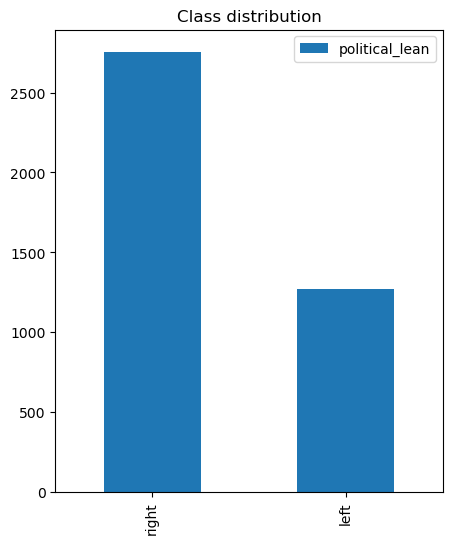

In [15]:
slct_tbl_full_df03['political_lean'].value_counts().plot(kind="bar",
                                                         legend=True,
                                                         figsize=(5,6),
                                                     title='Class distribution')

### Plot word counts

All sources seem to have very similar consolidation of most frequent word counts between 0 and 2,000. However, the two "left" sources (CNN and The Washington Post) seem to be the significant source of the outliers, with a small amount of articles each that have extremely large word counts (*note:* the x-axis range was truncated at 6,000 to make it more readabla--as noted above, there were some articles with word counts greater than 14,000). Given the simialirties between the sources within each class, the differences may correlate to intentional word limitation based on perceived audience desires, but in the very least do add evidence that the sources have been grouped together appropriately.

source_name
Breitbart News         Axes(0.125,0.11;0.775x0.77)
CNN                    Axes(0.125,0.11;0.775x0.77)
Fox News               Axes(0.125,0.11;0.775x0.77)
The Washington Post    Axes(0.125,0.11;0.775x0.77)
Name: word_cnt, dtype: object

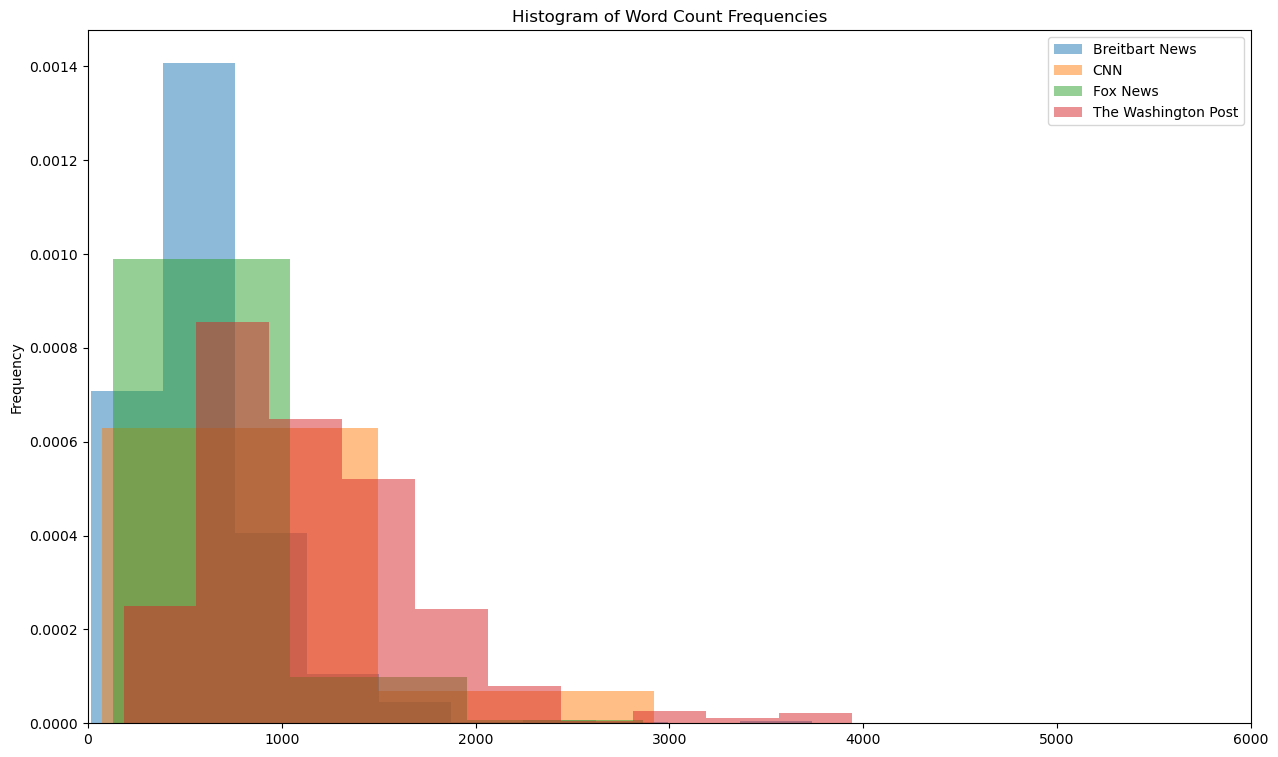

In [16]:
slct_tbl_full_df03.groupby('source_name')['word_cnt'].plot(kind="hist",
                                                           density=True,
                                                           alpha=0.5,
                                                           legend=True,
                                                           figsize=(15,9),
                                    title='Histogram of Word Count Frequencies',
                                                           xlim=(0,6000))

## Data preprocessing

In [17]:
def uniq_tok(df_col=None):
    '''Display all unique tokens across all instances'''
    df_cols1 = pd.Series(df_col)

    all_tokens_lst01 = []

    [all_tokens_lst01.append(f) for f in df_cols1]
    all_tokens_lst01 = list(itertools.chain.from_iterable(all_tokens_lst01))
    all_tokens_set01 = set(all_tokens_lst01)
    print(len(sorted(all_tokens_set01)))
    print(sorted(all_tokens_set01))

In [18]:
slct_tbl_full_df04 = slct_tbl_full_df03.copy()

### Case-loading

In [19]:
slct_tbl_full_df03['lower'] = slct_tbl_full_df03['article_text']\
.apply(str.lower)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

(4026, 12)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron..."


### Text normalization

#### Create function

In [20]:
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

#### Call function

In [21]:
slct_tbl_full_df03['norm'] = slct_tbl_full_df03['lower'].apply(normalize)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    try:
        print(slct_tbl_full_df03['norm'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 13)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron..."


travelers in alabama driving on interstate 65 to parties and barbecues on memorial day might have seen messages on digital road signs honoring veterans who died fighting for the united states. but that's not what some drivers near clanton, ala., saw on monday. instead, motorists reported seeing a sign that was apparently hacked to display the words "reclaim america," a white nationalist slogan, and "patriot front us," referencing the white supremacist group that was involved in the deadly 2017 unite the right rally in charlottesville. "how does this come about?" wrote sarah hughes, a motorist who captured photos of the sign and posted them on twitter. "weird as hell."  a contractor's portable message board was hacked on i-65 in chilton county, ala., on monday afternoon, john mcwilliams, a spokesman for the alabama department of transportation (aldot) west central region, told the washington post in a statement. "a citizen alerted a nearby state trooper about the message, who then conta

### Remove special characters

#### Create function

In [22]:
rex_sep = rex.compile(r'&nbsp;')
rex_ucode = rex.compile(r'[\\]u20*')

'''re.sub lambda citation:
https://chat.openai.com/share/402ec66e-2802-4cda-af8c-6f9f5b097d85
'''
sep_lst = []
ucode_lst = []
# Add leading and trailing space to URLs
def rex_replace(text):
    #txt = str(text)
    #print(lambda x: x.replace('&nbsp;', ' '))
    #sep_lst.append(rex_sep.findall(txt))
    #ucode_lst.append(rex_ucode.findall(txt))
    text = text.replace(r'&nbsp;', ' ').replace(r'-', ' ')\
    .replace(r'\n', ' ').replace('\u2063', ' ').replace('\u2066', ' ')\
    .replace('\u2069', ' ').replace('\u200b', ' ').replace('\u200d', ' ')
    #txt = txt
    #text = text.replace(r'200b', 'd171c')
    #text = rex_ucode.sub('', text)
    return text

#### Call function

In [23]:
slct_tbl_full_df03['replace'] = slct_tbl_full_df03['norm'].apply(rex_replace)

#print(ucode_lst)
#print(sep_lst)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

(4026, 14)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm,replace
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron..."


'''Complex citation (add lambda):
https://chat.openai.com/share/a135754c-c38c-47ea-8f83-54d41d5397ab
'''
slct_tbl_full_df03['replace'] = slct_tbl_full_df03['norm'].apply(lambda x: x.replace('&nbsp;', ' ').replace(r'\n', ' ').replace('\u2063', ' ').replace('\u2066', ' ').replace('\u2069', ' ').replace('\u200b', ' ').replace('\u200d', ' '))

### URL RegEx find

#### Create function

In [24]:
rex_url_c = rex.compile(r'http[s]?:[\/]+[\S]*\s')

'''re.sub lambda citation:
https://chat.openai.com/share/402ec66e-2802-4cda-af8c-6f9f5b097d85
'''
# Add leading and trailing space to URLs
def rex_url(text):
    text = rex_url_c.sub(lambda match: ' ' + match.group(0) + ' ', text)
    return text

#### Call function

In [25]:
slct_tbl_full_df03['rex_urls'] = slct_tbl_full_df03['replace'].apply(rex_url)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

(4026, 15)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm,replace,rex_urls
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron..."


### Separate emojis as individual tokens

#### Create function

In [26]:
def emoji_split(text):
    return("".join([' ' + c + ' ' if emoji.is_emoji(c) else c for c in text]))

#### Call function

In [27]:
slct_tbl_full_df03['emoji_split'] = slct_tbl_full_df03['rex_urls']\
.apply(emoji_split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    try:
        print(slct_tbl_full_df03['emoji_split'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 16)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm,replace,rex_urls,emoji_split
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron..."


travelers in alabama driving on interstate 65 to parties and barbecues on memorial day might have seen messages on digital road signs honoring veterans who died fighting for the united states. but that's not what some drivers near clanton, ala., saw on monday. instead, motorists reported seeing a sign that was apparently hacked to display the words "reclaim america," a white nationalist slogan, and "patriot front us," referencing the white supremacist group that was involved in the deadly 2017 unite the right rally in charlottesville. "how does this come about?" wrote sarah hughes, a motorist who captured photos of the sign and posted them on twitter. "weird as hell."  a contractor's portable message board was hacked on i 65 in chilton county, ala., on monday afternoon, john mcwilliams, a spokesman for the alabama department of transportation (aldot) west central region, told the washington post in a statement. "a citizen alerted a nearby state trooper about the message, who then conta

### Lemmatization using spaCY

In [28]:
nlp_trans = spacy.load('en_core_web_sm')

def lemma(text):
    trans_txt = nlp_trans(text)
    tokens = [t.lemma_ for t in trans_txt]
    return tokens

slct_tbl_full_df03['lemma'] = slct_tbl_full_df03['replace'].progress_apply(lemma)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    try:
        print(slct_tbl_full_df03['lemma'][c], '\n')
    except:
        print(f'Skip {c}')

#### Display globally unqiue tokens on lemmas

uniq_tok(df_col=slct_tbl_full_df03['lemma'])

### Split text

#### Apply

In [29]:
slct_tbl_full_df03['split'] = slct_tbl_full_df03['emoji_split']\
.apply(str.split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    try:
        print(slct_tbl_full_df03['split'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 17)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm,replace,rex_urls,emoji_split,split
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,"[travelers, in, alabama, driving, on, intersta..."
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,"[a, federal, prosecutor, may, be, nearing, a, ..."
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,"[a, federal, appeals, court, tuesday, cleared,..."
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","[speaking, in, orlando, in, november, 2015,, r..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","[""look,, we, know, our, country's, going, in, ..."


['travelers', 'in', 'alabama', 'driving', 'on', 'interstate', '65', 'to', 'parties', 'and', 'barbecues', 'on', 'memorial', 'day', 'might', 'have', 'seen', 'messages', 'on', 'digital', 'road', 'signs', 'honoring', 'veterans', 'who', 'died', 'fighting', 'for', 'the', 'united', 'states.', 'but', "that's", 'not', 'what', 'some', 'drivers', 'near', 'clanton,', 'ala.,', 'saw', 'on', 'monday.', 'instead,', 'motorists', 'reported', 'seeing', 'a', 'sign', 'that', 'was', 'apparently', 'hacked', 'to', 'display', 'the', 'words', '"reclaim', 'america,"', 'a', 'white', 'nationalist', 'slogan,', 'and', '"patriot', 'front', 'us,"', 'referencing', 'the', 'white', 'supremacist', 'group', 'that', 'was', 'involved', 'in', 'the', 'deadly', '2017', 'unite', 'the', 'right', 'rally', 'in', 'charlottesville.', '"how', 'does', 'this', 'come', 'about?"', 'wrote', 'sarah', 'hughes,', 'a', 'motorist', 'who', 'captured', 'photos', 'of', 'the', 'sign', 'and', 'posted', 'them', 'on', 'twitter.', '"weird', 'as', 'hell

#### Display globablly unqiue tokens on first split

In [30]:
#uniq_tok(df_col=slct_tbl_full_df03['split'])

### Remove stop words

In [31]:
sw = stopwords.words("english")

# Add additional stop words
sw.extend(['',
           '️',
           'arent',
           'cannot',
           'cant',
           'couldnt',
           'couldve',
           'didnt',
           'doesnt',
           'dont',
           'hadnt',
           'hasnt',
           'havent',
           'hes',
           'im',
           "i'm",
           'isnt',
           'it’s',
           'ive',
           '𝚘𝚏',
           'mightnt',
           'mustnt',
           'neednt',
           'shant',
           'shes',
           'shouldnt',
           'shouldve',
           'thatll',
           'theyll',
           'theyve',
           'wasnt',
           'werent',
           'whats',
           'weve',
           'wont',
           'wouldnt',
           'wouldve',
           'yall',
           'youd',
           'youll',
           'youre',
           'youve',
           "we'll",
           "you’re",
           "you’ve",
           "you’ll",
           "you’d",
           "she’s",
           "it’s",
           "that’ll",
           "don’t",
           "should’ve",
           "aren’t",
           "couldn’t",
           "didn’t",
           "doesn’t",
           "hadn’t",
           "hasn’t",
           "haven’t",
           "isn’t",
           "mightn’t",
           "mustn’t",
           "needn’t",
           "shan’t",
           "shouldn’t",
           "wasn’t",
           "weren’t",
           "won’t",
           "wouldn’t",
           "i’m",
           "we’ll",
           'said',
           'told',
           'according',
           'fox',
           'news',
           'cnn',
           'breitbart',
           'reuters'])

print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### Create function

In [32]:
def sw_remover(tokens):
    return [t for t in tokens if t.lower() not in sw]

#### Call function

In [33]:
slct_tbl_full_df03['no_sw'] = slct_tbl_full_df03['split'].apply(sw_remover)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    print(slct_tbl_full_df03['no_sw'][c])

(4026, 18)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm,replace,rex_urls,emoji_split,split,no_sw
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,"[travelers, in, alabama, driving, on, intersta...","[travelers, alabama, driving, interstate, 65, ..."
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,"[a, federal, prosecutor, may, be, nearing, a, ...","[federal, prosecutor, may, nearing, decision, ..."
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,"[a, federal, appeals, court, tuesday, cleared,...","[federal, appeals, court, tuesday, cleared, wa..."
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","[speaking, in, orlando, in, november, 2015,, r...","[speaking, orlando, november, 2015,, republica..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","[""look,, we, know, our, country's, going, in, ...","[""look,, know, country's, going, wrong, direct..."


['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might', 'seen', 'messages', 'digital', 'road', 'signs', 'honoring', 'veterans', 'died', 'fighting', 'united', 'states.', "that's", 'drivers', 'near', 'clanton,', 'ala.,', 'saw', 'monday.', 'instead,', 'motorists', 'reported', 'seeing', 'sign', 'apparently', 'hacked', 'display', 'words', '"reclaim', 'america,"', 'white', 'nationalist', 'slogan,', '"patriot', 'front', 'us,"', 'referencing', 'white', 'supremacist', 'group', 'involved', 'deadly', '2017', 'unite', 'right', 'rally', 'charlottesville.', '"how', 'come', 'about?"', 'wrote', 'sarah', 'hughes,', 'motorist', 'captured', 'photos', 'sign', 'posted', 'twitter.', '"weird', 'hell."', "contractor's", 'portable', 'message', 'board', 'hacked', '65', 'chilton', 'county,', 'ala.,', 'monday', 'afternoon,', 'john', 'mcwilliams,', 'spokesman', 'alabama', 'department', 'transportation', '(aldot)', 'west', 'central', 'region,', 'washington', 'post

#### Display no stop words

In [34]:
#uniq_tok(df_col=slct_tbl_full_df03['no_sw'])

### Rejoin semi-processed tokens

In [35]:
slct_tbl_full_df03['no_sw_join'] = slct_tbl_full_df03['no_sw'].apply(" ".join)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    print(slct_tbl_full_df03['no_sw_join'][c])

(4026, 19)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm,replace,rex_urls,emoji_split,split,no_sw,no_sw_join
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,"[travelers, in, alabama, driving, on, intersta...","[travelers, alabama, driving, interstate, 65, ...",travelers alabama driving interstate 65 partie...
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,"[a, federal, prosecutor, may, be, nearing, a, ...","[federal, prosecutor, may, nearing, decision, ...",federal prosecutor may nearing decision whethe...
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,"[a, federal, appeals, court, tuesday, cleared,...","[federal, appeals, court, tuesday, cleared, wa...",federal appeals court tuesday cleared way drug...
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","[speaking, in, orlando, in, november, 2015,, r...","[speaking, orlando, november, 2015,, republica...","speaking orlando november 2015, republican pre..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","[""look,, we, know, our, country's, going, in, ...","[""look,, know, country's, going, wrong, direct...","""look, know country's going wrong direction,"" ..."


travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states. that's drivers near clanton, ala., saw monday. instead, motorists reported seeing sign apparently hacked display words "reclaim america," white nationalist slogan, "patriot front us," referencing white supremacist group involved deadly 2017 unite right rally charlottesville. "how come about?" wrote sarah hughes, motorist captured photos sign posted twitter. "weird hell." contractor's portable message board hacked 65 chilton county, ala., monday afternoon, john mcwilliams, spokesman alabama department transportation (aldot) west central region, washington post statement. "a citizen alerted nearby state trooper message, contacted aldot," mcwilliams tuesday. "aldot personnel immediately responded turned message board off. message boards 65 affected." mcwilliams added aldot investigating white supremacist language appeared sign near cl

### Remove punctuation

In [36]:
punctuation = set(punctuation) # speeds up comparison
#print(punctuation)

# Add special hyphen mark
tw_punct = punctuation - {"#"}
#print(tw_punct)

# Remove hash and at symbols for later capture of hashtag info
tw_punct = tw_punct - {"@"}
tw_punct = tw_punct - {"-"}
#tw_punct = tw_punct - {"/"}
tw_punct.add("’")
tw_punct.add("‘")
tw_punct.add("”")
tw_punct.add("“")
tw_punct.add("…")
tw_punct.add("—")
tw_punct.add("...")
tw_punct.add("€")
tw_punct.add("±")
tw_punct.add("£")
tw_punct.add("¡")
tw_punct.add("§")
tw_punct.add("⦿")

print(tw_punct)

{'&', '…', '?', '\\', ',', '£', '⦿', '±', '§', '_', '>', ')', '(', "'", '`', '—', ';', '|', '{', '"', '[', '=', '+', '%', '/', '’', '<', '€', '}', '”', '!', ':', '^', '“', '~', '¡', '*', '$', '.', '...', '‘', ']'}


#### Create function

In [37]:
def remove_punctuation(text, punct_set=tw_punct): 
    return("".join([ch for ch in text if ch not in punct_set]))

#### Call function

In [38]:
slct_tbl_full_df03['no_sw_join_no_punc'] = slct_tbl_full_df03['no_sw_join']\
.apply(remove_punctuation, punct_set=tw_punct)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    try:
        print(slct_tbl_full_df03['no_sw_join_no_punc'][c], '\n')
    except:
        print(f'\nerror on {c}\n')

(4026, 20)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,lower,norm,replace,rex_urls,emoji_split,split,no_sw,no_sw_join,no_sw_join_no_punc
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,"[travelers, in, alabama, driving, on, intersta...","[travelers, alabama, driving, interstate, 65, ...",travelers alabama driving interstate 65 partie...,travelers alabama driving interstate 65 partie...
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,"[a, federal, prosecutor, may, be, nearing, a, ...","[federal, prosecutor, may, nearing, decision, ...",federal prosecutor may nearing decision whethe...,federal prosecutor may nearing decision whethe...
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,"[a, federal, appeals, court, tuesday, cleared,...","[federal, appeals, court, tuesday, cleared, wa...",federal appeals court tuesday cleared way drug...,federal appeals court tuesday cleared way drug...
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","[speaking, in, orlando, in, november, 2015,, r...","[speaking, orlando, november, 2015,, republica...","speaking orlando november 2015, republican pre...",speaking orlando november 2015 republican pres...
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","[""look,, we, know, our, country's, going, in, ...","[""look,, know, country's, going, wrong, direct...","""look, know country's going wrong direction,"" ...",look know countrys going wrong direction flori...


travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states thats drivers near clanton ala saw monday instead motorists reported seeing sign apparently hacked display words reclaim america white nationalist slogan patriot front us referencing white supremacist group involved deadly 2017 unite right rally charlottesville how come about wrote sarah hughes motorist captured photos sign posted twitter weird hell contractors portable message board hacked 65 chilton county ala monday afternoon john mcwilliams spokesman alabama department transportation aldot west central region washington post statement a citizen alerted nearby state trooper message contacted aldot mcwilliams tuesday aldot personnel immediately responded turned message board off message boards 65 affected mcwilliams added aldot investigating white supremacist language appeared sign near clanton 40 miles northwest montgomery ala of

### Tokenize

In [39]:
slct_tbl_full_df03['no_sw_join_no_punc_tok'] \
= slct_tbl_full_df03['no_sw_join_no_punc'].apply(str.split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,1):
    print(slct_tbl_full_df03['no_sw_join_no_punc_tok'][c], '\n')

(4026, 21)


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,...,lower,norm,replace,rex_urls,emoji_split,split,no_sw,no_sw_join,no_sw_join_no_punc,no_sw_join_no_punc_tok
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,travelers in alabama driving on interstate 65 ...,"[travelers, in, alabama, driving, on, intersta...","[travelers, alabama, driving, interstate, 65, ...",travelers alabama driving interstate 65 partie...,travelers alabama driving interstate 65 partie...,"[travelers, alabama, driving, interstate, 65, ..."
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,a federal prosecutor may be nearing a decision...,"[a, federal, prosecutor, may, be, nearing, a, ...","[federal, prosecutor, may, nearing, decision, ...",federal prosecutor may nearing decision whethe...,federal prosecutor may nearing decision whethe...,"[federal, prosecutor, may, nearing, decision, ..."
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,a federal appeals court tuesday cleared the wa...,"[a, federal, appeals, court, tuesday, cleared,...","[federal, appeals, court, tuesday, cleared, wa...",federal appeals court tuesday cleared way drug...,federal appeals court tuesday cleared way drug...,"[federal, appeals, court, tuesday, cleared, wa..."
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,...,"speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","speaking in orlando in november 2015, republic...","[speaking, in, orlando, in, november, 2015,, r...","[speaking, orlando, november, 2015,, republica...","speaking orlando november 2015, republican pre...",speaking orlando november 2015 republican pres...,"[speaking, orlando, november, 2015, republican..."
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,...,"“look, we know our country’s going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","""look, we know our country's going in the wron...","[""look,, we, know, our, country's, going, in, ...","[""look,, know, country's, going, wrong, direct...","""look, know country's going wrong directi

['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might', 'seen', 'messages', 'digital', 'road', 'signs', 'honoring', 'veterans', 'died', 'fighting', 'united', 'states', 'thats', 'drivers', 'near', 'clanton', 'ala', 'saw', 'monday', 'instead', 'motorists', 'reported', 'seeing', 'sign', 'apparently', 'hacked', 'display', 'words', 'reclaim', 'america', 'white', 'nationalist', 'slogan', 'patriot', 'front', 'us', 'referencing', 'white', 'supremacist', 'group', 'involved', 'deadly', '2017', 'unite', 'right', 'rally', 'charlottesville', 'how', 'come', 'about', 'wrote', 'sarah', 'hughes', 'motorist', 'captured', 'photos', 'sign', 'posted', 'twitter', 'weird', 'hell', 'contractors', 'portable', 'message', 'board', 'hacked', '65', 'chilton', 'county', 'ala', 'monday', 'afternoon', 'john', 'mcwilliams', 'spokesman', 'alabama', 'department', 'transportation', 'aldot', 'west', 'central', 'region', 'washington', 'post', 'statement', 'a', 'citizen', 

#### Display globally unqiue tokens on final tokens

In [40]:
#uniq_tok(df_col=slct_tbl_full_df03['no_sw_join_no_punc_tok'])

### Pipeline consolidation

#### Pipeline function

In [41]:
def prepare(text, pipeline):
    '''Run a pipeline of text processing transformers'''
    tokens = str(text)
    
    # Pull key and val from trans dictionaries
    for transformer in pipeline:
        trans = list(transformer.keys())[0]
        args = list(transformer.values())[0]
        #print(trans)
        #print(args)
        if args == None:
            #print(1)
            tokens = trans(tokens)
        else:
            #print('check99', trans, args)
            tokens = trans(tokens, args) 

    return(tokens)

#### `article_text` preprocessing - w/o lemmatization

In [42]:
'''Set transformer pipeline 1:
Caseloading, normalization (using textacy), special ch removal,
split on whitespace, stop word removal, rejoin,
remove custom punctuation, tokenize
'''
transformers01 = [{str.lower: None},
                  {normalize: None},
                  {rex_replace: None},
                  {rex_url: None},
                  {emoji_split: None},
                  {str.split: None},
                  {sw_remover: None},
                  {" ".join: None},
                  {remove_punctuation: tw_punct},
                  {str.split: None},
                  {" ".join: None},
                 ]

# Apply transformers to pandas dataframe, w/ new col containing tokens
slct_tbl_full_df04['processed_text'] = slct_tbl_full_df04['article_text']\
.progress_apply(prepare, pipeline=transformers01)

slct_tbl_full_df04['processed_text_split'] = slct_tbl_full_df04['processed_text']\
.progress_apply(str.split)

slct_tbl_full_df04['num_tokens'] = slct_tbl_full_df04['processed_text_split']\
.map(len)

display(slct_tbl_full_df04.head())

# Review unique tokens across entire dataset
for c in range(0,1):
    try:
        print(slct_tbl_full_df04['processed_text'][c], '\n')
    except:
        print(f'Skip {c}')

100%|██████| 4026/4026 [00:00<00:00, 29452.30it/s]


,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,processed_text,processed_text_split,num_tokens
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers alabama driving interstate 65 partie...,"[travelers, alabama, driving, interstate, 65, ...",563
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,federal prosecutor may nearing decision whethe...,"[federal, prosecutor, may, nearing, decision, ...",648
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,federal appeals court tuesday cleared way drug...,"[federal, appeals, court, tuesday, cleared, wa...",524
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,speaking orlando november 2015 republican pres...,"[speaking, orlando, november, 2015, republican...",543
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,look know countrys going wrong direction flori...,"[look, know, countrys, going, wrong, direction...",398


travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states thats drivers near clanton ala saw monday instead motorists reported seeing sign apparently hacked display words reclaim america white nationalist slogan patriot front us referencing white supremacist group involved deadly 2017 unite right rally charlottesville how come about wrote sarah hughes motorist captured photos sign posted twitter weird hell contractors portable message board hacked 65 chilton county ala monday afternoon john mcwilliams spokesman alabama department transportation aldot west central region washington post statement a citizen alerted nearby state trooper message contacted aldot mcwilliams tuesday aldot personnel immediately responded turned message board off message boards 65 affected mcwilliams added aldot investigating white supremacist language appeared sign near clanton 40 miles northwest montgomery ala of

##### Display globally unqiue tokens on final tokens

In [43]:
#uniq_tok(df_col=slct_tbl_full_df04['processed_text_split'])

#### `article_text` preprocessing - w/ lemmatization

'''Set transformer pipeline 2:
Caseloading, normalization (using textacy), special ch removal,
lemmitization, stop word removal, rejoin,
remove custom punctuation, tokenize
'''
transformers02 = [{str.lower: None},
                  {normalize: None},
                  {rex_replace: None},
                  {lemma: None},
                  {" ".join: None},
                  {rex_url: None},
                  {emoji_split: None},
                  {str.split: None},
                  {sw_remover: None},
                  {" ".join: None},
                  {remove_punctuation: tw_punct},
                  {str.split: None},
                  {" ".join: None},
                 ]

# Apply transformers to pandas dataframe, w/ new col containing tokens
slct_tbl_full_df04['processed_lemmas'] = slct_tbl_full_df04['article_text']\
.progress_apply(prepare, pipeline=transformers02)

slct_tbl_full_df04['processed_lemmas_split'] = slct_tbl_full_df04['processed_lemmas']\
.progress_apply(str.split)

slct_tbl_full_df04['num_lemmas'] = slct_tbl_full_df04['processed_lemmas_split']\
.map(len)

display(slct_tbl_full_df04.head())

# Review unique tokens across entire dataset
for c in range(0,1):
    try:
        print(slct_tbl_full_df04['processed_lemmas'][c], '\n')
    except:
        print(f'Skip {c}')

##### Display globally unqiue tokens on final tokens

In [44]:
#uniq_tok(df_col=slct_tbl_full_df04['processed_lemmas_split'])

### Calculate concentration ratio of each set of corpora

In [45]:
display(slct_tbl_full_df04['political_lean'].value_counts())

slct_tbl_full_df04_left = slct_tbl_full_df04[\
                                             slct_tbl_full_df04[\
                                                'political_lean'] == 'left']

print(slct_tbl_full_df04_left.shape)
#display(slct_tbl_full_df04_left.head())

slct_tbl_full_df04_right = slct_tbl_full_df04[\
                                              slct_tbl_full_df04[\
                                                'political_lean'] == 'right']

print(slct_tbl_full_df04_right.shape)
#display(slct_tbl_full_df04_right.head())

slct_tbl_full_df04_left_s1 = list(itertools.chain.from_iterable(
    list(pd.Series(slct_tbl_full_df04_left['processed_text_split']))))
print(slct_tbl_full_df04_left_s1[:10])
slct_tbl_full_df04_right_s1 = list(itertools.chain.from_iterable(
    list(pd.Series(slct_tbl_full_df04_right['processed_text_split']))))
print(slct_tbl_full_df04_right_s1[:10])

right    2758
left     1268
Name: political_lean, dtype: int64

(1268, 14)
(2758, 14)
['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might']
['family', 'jennifer', 'farber', 'dulos', 'released', 'statement', 'wednesday', 'marking', 'four', 'years']


In [46]:
def concen_ratio(artist_lst=[],
                 lsts=[]):
    lyr_corp_lst = []
    for l in lsts:
        print(type(l))
        lyr_corp_lst.append(' '.join(l))
    print(len(lyr_corp_lst))
    #print(lyr_corp_lst)

    cv = CountVectorizer(input='content',
                         encoding='utf-8',
                         stop_words=None,
                         token_pattern=r'\S+'
                        )

    lyr_tokens_fit = cv.fit(lyr_corp_lst)

    print(pd.Series(cv.get_feature_names_out()).sample(15))

    lyr_tokens_sm = cv.transform(lyr_corp_lst)
    display(lyr_tokens_sm)

    df = pd.DataFrame(lyr_tokens_sm.toarray(),
                      columns=cv.get_feature_names_out())
    #display(df)

    df02 = df.copy()
    df02['r_sum'] = df02.sum(axis=1)
    #display(df02)

    '''Filter by frequency for all columns citation:
    OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
    https://pandas.pydata.org/pandas-docs/stable/reference/api/
    pandas.DataFrame.ge.html'''
    condition = df.ge(5).all()
    #print(condition)

    # Get the list of columns that satisfy the condition
    columns = condition[condition].index.tolist()
    #print(columns)
    columns.append('r_sum')
    #print(columns)

    #display(df02[columns])

    df03 = df02[columns].copy()
    display(df03)

    '''Filter by frequency for all columns & add summary row citation:
    OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/'''
    df04 = df03.apply(lambda x: x / df03.iloc[:,-1], axis=0)
    #display(df04)

    # Create new rows by dividing one artist row by the second artists row
    new_row01 = df04.iloc[0] / df04.iloc[1]
    new_row02 = df04.iloc[1] / df04.iloc[0]

    # Append the new row to the DataFrame
    df04 = df04.append(new_row01, ignore_index=True)
    df04 = df04.append(new_row02, ignore_index=True)
    display(df04)

    # Transpose dataframe
    df05 = df04.T
    df05 = df05.reset_index()
    df05.columns = ['token',
                    'c1_concen',
                    'c2_concen',
                    'c1c2_concen_ratio',
                    'c2c1_concen_ratio']
    #print(df05)
    
    '''Sort values citation:
    https://pandas.pydata.org/pandas-docs/stable/reference/api
    /pandas.DataFrame.sort_values.html'''
    print(artist_lst[0])
    display(df05[['token',
                  'c1c2_concen_ratio']].sort_values(by='c1c2_concen_ratio',
                                                    ascending=False).head(10))
    print(artist_lst[1])
    display(df05[['token',
                  'c2c1_concen_ratio']].sort_values(by='c2c1_concen_ratio',
                                                    ascending=False).head(10))

concen_ratio(artist_lst=['Left-Right Concentration Ratio',
                         'Right-Left Concentration Ratio'],
             lsts=[slct_tbl_full_df04_left_s1,
                   slct_tbl_full_df04_right_s1])

<class 'list'>
<class 'list'>
2
20374       floundering
51550            uncles
19319             faint
52172         unspoiled
1652              44000
9172               bulb
2278                886
15867       disciplined
47639    stockification
23283            harita
9252            buoying
27154            jabbed
21788           ghastly
24995             human
22431        grapefruit
dtype: object


<2x55719 sparse matrix of type '<class 'numpy.int64'>'
	with 79419 stored elements in Compressed Sparse Row format>

,#2,#metoo,0,07,1,10,100,1000,10000,100000,...,zero,zip,zone,zones,zoo,zoom,zuckerberg,–,•,r_sum
0,6,18,16,5,452,397,138,65,52,45,...,67,6,38,7,11,16,13,2390,53,756208
1,5,8,36,6,600,638,226,82,124,64,...,97,11,38,11,40,17,7,1583,78,1062132


C:\Users\acarr\AppData\Local\Temp\ipykernel_21248\3142308763.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df04 = df04.append(new_row01, ignore_index=True)
C:\Users\acarr\AppData\Local\Temp\ipykernel_21248\3142308763.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df04 = df04.append(new_row02, ignore_index=True)


,#2,#metoo,0,07,1,10,100,1000,10000,100000,...,zero,zip,zone,zones,zoo,zoom,zuckerberg,–,•,r_sum
0,7.9343e-06,2.3803e-05,2.1158e-05,6.6119e-06,0.0006,0.0005,0.0002,8.5955e-05,6.8764e-05,5.9507e-05,...,8.8600e-05,7.9343e-06,5.0251e-05,9.2567e-06,1.4546e-05,2.1158e-05,1.7191e-05,0.0032,7.0087e-05,1.0
1,4.7075e-06,7.5320e-06,3.3894e-05,5.6490e-06,0.0006,0.0006,0.0002,7.7203e-05,1.1675e-04,6.0256e-05,...,9.1326e-05,1.0357e-05,3.5777e-05,1.0357e-05,3.7660e-05,1.6006e-05,6.5905e-06,0.0015,7.3437e-05,1.0
2,1.6855e+00,3.1602e+00,6.2424e-01,1.1705e+00,1.0581,0.8740,0.8576,1.1134e+00,5.8900e-01,9.8757e-01,...,9.7015e-01,7.6612e-01,1.4046e+00,8.9380e-01,3.8625e-01,1.3219e+00,2.6085e+00,2.1206,9.5437e-01,1.0
3,5.9331e-01,3.1643e-01,1.6019e+00,8.5437e-01,0.9451,1.1442,1.1660,8.9818e-01,1.6978e+00,1.0126e+00,...,1.0308e+00,1.3053e+00,7.1197e-01,1.1188e+00,2.5890e+00,7.5647e-01,3.8337e-01,0.4716,1.0478e+00,1.0


Left-Right Concentration Ratio


,token,c1c2_concen_ratio
723,anonymity,17.5569
9885,thomass,16.2928
10775,willis,14.3264
6202,mehta,13.7334
3116,docket,13.2028
4350,ginni,12.3600
7422,pork,11.7046
10225,uncertainty,10.0479
4401,gorsuch,9.8319
4874,hush,9.8319


Right-Left Concentration Ratio


,token,c2c1_concen_ratio
1945,click,88.7452
2395,copyright,22.2745
6726,nyc,17.3246
8201,reparations,16.7313
2076,commenting,14.2394
755,ap,14.0812
765,app,13.0920
579,aliens,12.5782
1699,ccp,11.3915
5911,locker,10.9644


### KWIC

In [104]:
def kwic(doc_series, keyword, window=35, print_samples=5):
    '''Search article text for keywords in context (KWIC)'''
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(doc=text,
                              keyword=keyword,
                              ignore_case=True,
                              window_width=window))
    kwic_list = []
    doc_series.map(add_kwic)
    
    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)}" + \
              f" contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+' '+\
                  sample[1]+' '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [112]:
kwic(slct_tbl_full_df04['article_text'], ' ccp ', window=100, print_samples=20)

20 random samples out of 73 contexts for ' ccp ':
t argues, was due to politics.  YALE STUDENTS SLAM UNIVERSITY PRESIDENT FOR ATTENDING NYC EVENT WITH  CCP  OFFICIAL WHO 'DEFENDED' GENOCIDE "Despite Republicans holding the majority of the attorney general o
bsp; The Biden administration in March also looked to tackle potential security threats posed by the  CCP  by demanding that TikTok owners divert their stakes – a move that Republicans are currently calling 
for allowing the CCP and other hostile actors to amass influence at their institutions.&nbsp; "[The]  CCP  is the biggest threat to America," Rep. Michelle Steel, R-Calif., told Fox News Digital. "So they to
CLUSIVE: CHINESE DONORS TO UNIVERSITY HOUSING BIDEN THINK TANK HAVE TIES TO HUNTER'S BUSINESS DEALS,  CCP   That number was later found to be at least $6.5 billion in unreported funding from foreign countrie
 asserted, “The climate agenda is a lie: fossil fuels are a requirement for human prosperity.”  “The  CCP  is playing 

### Train/test split

In [49]:
slct_tbl_full_df04['stratifier'] = slct_tbl_full_df04['political_lean']\
.astype(str) + slct_tbl_full_df04['source_name'].astype(str)
slct_tbl_full_df04['stratifier'] = slct_tbl_full_df04['stratifier']\
.map(str.lower)
display(slct_tbl_full_df04.head())

y01a = ['stratifier']
slct_tbl_full_df04_y01_vc01a = slct_tbl_full_df04[y01a].to_numpy()
print(slct_tbl_full_df04_y01_vc01a.shape)

y01 = ['political_lean']
slct_tbl_full_df04_y01_vc01 = slct_tbl_full_df04[y01].to_numpy()
print(slct_tbl_full_df04_y01_vc01.shape)

,index,source_name,author,title,url,publish_date,content,article_text,char_cnt,word_cnt,political_lean,processed_text,processed_text_split,num_tokens,stratifier
0,0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,5746,920,left,travelers alabama driving interstate 65 partie...,"[travelers, alabama, driving, interstate, 65, ...",563,leftthe washington post
1,1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,6814,1089,left,federal prosecutor may nearing decision whethe...,"[federal, prosecutor, may, nearing, decision, ...",648,leftthe washington post
2,2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,5479,869,left,federal appeals court tuesday cleared way drug...,"[federal, appeals, court, tuesday, cleared, wa...",524,leftthe washington post
3,3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...",5907,955,left,speaking orlando november 2015 republican pres...,"[speaking, orlando, november, 2015, republican...",543,leftthe washington post
4,5,The Washington Post,Paul Waldman,Why fear of change will drive the GOP presiden...,https://www.washingtonpost.com/opinions/2023/0...,2023-05-30T10:00:00Z,"Comment on this story\r\nComment\r\nLook, we k...","“Look, we know our country’s going in the wron...",4563,750,left,look know countrys going wrong direction flori...,"[look, know, countrys, going, wrong, direction...",398,leftthe washington post


(4026, 1)
(4026, 1)


In [50]:
nlm_train_x01, \
nlm_test_x01, \
nlm_train_y01, \
nlm_test_y01 = train_test_split(slct_tbl_full_df04['processed_text'],
                                slct_tbl_full_df04_y01_vc01,
                                test_size=.15,
                                random_state=1699,
                                stratify=slct_tbl_full_df04_y01_vc01a
                               )

nlm_train_y01 = nlm_train_y01.ravel()
nlm_test_y01 = nlm_test_y01.ravel()

print(f'{nlm_train_x01.shape}')
print(f'{nlm_train_y01.shape}')
print(f'\n{nlm_test_x01.shape}')
print(f'{nlm_test_y01.shape}')

(3422,)
(3422,)

(604,)
(604,)


lem_train_x01, \
lem_test_x01, \
lem_train_y01, \
lem_test_y01 = train_test_split(slct_tbl_full_df04['processed_lemmas'],
                                slct_tbl_full_df04_y01_vc01,
                                test_size=.15,
                                random_state=1699,
                                stratify=slct_tbl_full_df04_y01_vc01a
                               )

lem_train_y01 = lem_train_y01.ravel()
lem_test_y01 = lem_test_y01.ravel()

print(f'{lem_train_x01.shape}')
print(f'{lem_train_y01.shape}')
print(f'\n{lem_test_x01.shape}')
print(f'{lem_test_y01.shape}')

### TF-IDF

In [51]:
print(slct_tbl_full_df04['processed_text'].shape)
print(slct_tbl_full_df04['processed_text'].head())

(4026,)
0    travelers alabama driving interstate 65 partie...
1    federal prosecutor may nearing decision whethe...
2    federal appeals court tuesday cleared way drug...
3    speaking orlando november 2015 republican pres...
4    look know countrys going wrong direction flori...
Name: processed_text, dtype: object


In [52]:
nlm_tfidf = TfidfVectorizer(encoding='utf-8',
                            analyzer='word',
                            stop_words=sw,
                            token_pattern=r'(?u)\b\w\w+\b',
                            ngram_range=(1,3),
                            max_df=.7,
                            min_df=5)

nlm_train_x01_mtx = nlm_tfidf.fit_transform(nlm_train_x01)
nlm_test_x01_mtx = nlm_tfidf.transform(nlm_test_x01)

display(nlm_train_x01_mtx)
display(nlm_test_x01_mtx)

<3422x49302 sparse matrix of type '<class 'numpy.float64'>'
	with 1275306 stored elements in Compressed Sparse Row format>

<604x49302 sparse matrix of type '<class 'numpy.float64'>'
	with 218436 stored elements in Compressed Sparse Row format>

lem_tfidf = TfidfVectorizer(encoding='utf-8',
                            analyzer='word',
                            stop_words=sw,
                            token_pattern=r'(?u)\b\w\w+\b',
                            ngram_range=(1,3),
                            max_df=.7,
                            min_df=5)

lem_train_x01_mtx = lem_tfidf.fit_transform(lem_train_x01)
lem_test_x01_mtx = lem_tfidf.transform(lem_test_x01)

display(lem_train_x01_mtx)
display(lem_test_x01_mtx)

In [82]:
def display_samp_dwm(sm=None,
                     vec=None,
                     n=(1,1),
                     rs_tup=(1,1)):
    mtx_df01 = pd.DataFrame(sm.toarray(),
                            columns=vec.get_feature_names_out())

    mtx_df01a = mtx_df01.sample(n=n[0],
                                random_state=rs_tup[0],
                                axis=1)

    mtx_df01b = mtx_df01a.sample(n=n[1],
                                 random_state=rs_tup[1],
                                 axis=0)

    display(mtx_df01b)
    return vec.get_feature_names_out()

In [54]:
rs_tup=(1699,1699)

In [83]:
nlm_train_x01_mtx_cols = display_samp_dwm(sm=nlm_train_x01_mtx,
                                          vec=nlm_tfidf,
                                          n=(17,11),
                                          rs_tup=(5,1699))

,banking committee,drug treatment,jake,million dollars,government service,among conservatives,humanitarian reasons significant,2024 presidential,trump making,opens door,approval,young women,tool gives,polling station,continue reading,several states,state ban
1098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


display_samp_dwm(sm=lem_train_x01_mtx,
                 vec=lem_tfidf,
                 n=(17,11),
                 rs_tup=(5,1699))

## Modeling

### Algorithm setup

### Gradient Boosting Classifier - Using `BayesSearchCV`

from sklearn.model_selection import RepeatedStratifiedKFold

# Start timer script
start_time = dt.datetime.today()

# Citation: Hochberg, 2018; Shanmukh, 2021
m2v1_gbc_pip = Pipeline([('gbc',
                          GradientBoostingClassifier(random_state=1699))])

loss_hparam = Categorical(['log_loss', 'exponential'])
lrate_hparam = Real(1e-3, 1e3, prior='log-uniform')
nest_hparam = Integer(1e2, 1e3, prior='log-uniform')
msamp_hparam = Real(.01, .95, prior='log-uniform')
mdepth_hparam = Integer(1, 20, prior='log-uniform')
mfeat_hparam = Categorical(['sqrt', 'log2', None])
#wstart_hparam = Categorical([True, False])
#calph_hparam = Real(0.0, 100.0, prior='log-uniform')
                #'gbc__warm_start': wstart_hparam
                #'gbc__ccp_alpha': calph_hparam

m2v1_gbc_grd = {'gbc__loss': loss_hparam,
                'gbc__learning_rate': lrate_hparam,
                'gbc__n_estimators': nest_hparam,
                'gbc__min_samples_split': msamp_hparam,
                'gbc__max_depth': mdepth_hparam,
                'gbc__max_features': mfeat_hparam
               }

'''Change GBC default scoring from accuracy to F1 score citation:
https://chat.openai.com/share/254f382b-4a8e-48e8-acd5-2918f0bbc59d
'''
f1_scorer = make_scorer(f1_score,
                        pos_label='right')

'''Customize cross-validation citation:
https://machinelearningmastery.com
/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/
'''
cv = RepeatedStratifiedKFold(n_splits=5,
                             n_repeats=2,
                             random_state=1699)

m2v1_gbc = BayesSearchCV(m2v1_gbc_pip,
                         m2v1_gbc_grd,
                         n_iter=15,
                         scoring=f1_scorer,
                         cv=cv,
                         n_jobs=3,
                         refit=True,
                         verbose=4,
                         random_state=1699)

m2v1_gbc.fit(nlm_train_x01_mtx, nlm_train_y01)

# End timer script
end_time = dt.datetime.today()
time_elapse = end_time - start_time
print(f'Start Time = {start_time}')
print(f'End Time = {end_time}')
print(f'Elapsed Time = {time_elapse}')

### Pickle best model

In [56]:
# Path to save the pickled model

mod_folder_name = 'trained_models'
m2v1_pkl_file_name = 'm2v1_gbc.pkl'


pkl_file_path01 = os.path.join(curr_dir, mod_folder_name, m2v1_pkl_file_name)

print(f'CSV file 1 in path: {pkl_file_path01}')

CSV file 1 in path: C:\Users\acarr\Documents\GitHub\ADS509_Final_project\deliverables\trained_models\m2v1_gbc.pkl


with open(pkl_file_path01, "wb") as file:
    pickle.dump(m2v1_gbc, file)

print("Model pickled and saved successfully.")

### Load pickled best model

In [57]:
with open(pkl_file_path01, 'rb') as file:
    m2v1_gbc = pickle.load(file)

In [58]:
print(f'\nBest Estimator:\n{m2v1_gbc.best_estimator_}')

print('\nCross-validaton results:')
display(pd.DataFrame(m2v1_gbc.cv_results_))

train_m2v1_gbc_y01_pred = m2v1_gbc.predict_proba(nlm_train_x01_mtx)
print(f'\nFirst 10 train set predictions:\n{train_m2v1_gbc_y01_pred[:10]}')

test_m2v1_gbc_y01_pred = m2v1_gbc.predict_proba(nlm_test_x01_mtx)
print(f'\nFirst 10 test set predictions:\n{test_m2v1_gbc_y01_pred[:10]}')

print(f'\nBest Score for "{m2v1_gbc.scorer_}" is {m2v1_gbc.best_score_}')


Best Estimator:
Pipeline(steps=[('gbc',
                 GradientBoostingClassifier(learning_rate=1.443983517854453,
                                            loss='exponential', max_depth=20,
                                            max_features='log2',
                                            min_samples_split=0.5120315024377693,
                                            n_estimators=1000,
                                            random_state=1699))])

Cross-validaton results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_split,param_gbc__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,12.6265,1.2722,0.0266,7.1826e-03,0.0162,log_loss,1,log2,0.0119,510,...,0.8149,0.8132,0.8135,0.8135,0.8149,0.8142,0.8139,0.8141,0.0008,9
1,11.8357,1.1532,0.0282,6.1911e-03,0.035,exponential,1,sqrt,0.2197,403,...,0.8736,0.8737,0.8743,0.8828,0.8724,0.8776,0.8887,0.8791,0.0064,6
2,3.2453,0.3068,0.0250,7.6687e-03,55.3871,exponential,3,sqrt,0.8602,108,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1701,0.0984,0.2437,13
3,317.1236,21.4360,0.0313,7.3904e-06,4.7311,exponential,6,None,0.0114,232,...,0.9576,0.8418,0.8434,0.8307,0.9539,0.9443,0.9497,0.9059,0.0548,5
4,6.3836,0.5247,0.0399,1.0156e-02,25.6546,log_loss,5,log2,0.0535,189,...,0.0408,0.7731,0.0683,0.0607,0.0370,0.1029,0.1222,0.1672,0.2181,12
5,13.6031,1.3130,0.0554,1.0068e-02,23.2484,log_loss,11,log2,0.0484,406,...,0.7789,0.2301,0.1835,0.1059,0.1061,0.7680,0.1508,0.3326,0.2862,11
6,12.4504,1.2054,0.0500,9.3930e-03,173.3432,log_loss,11,log2,0.3327,377,...,0.0168,0.7692,0.0085,0.0000,0.0042,0.0043,0.0000,0.0803,0.2297,14
7,237.9337,23.0674,0.0266,7.1457e-03,36.8407,exponential,3,None,0.0303,309,...,0.7751,0.9055,0.7675,0.8093,0.8032,0.8982,0.9172,0.8614,0.0607,7
8,7.4626,1.0567,0.0299,4.9103e-03,274.3051,log_loss,1,log2,0.4011,256,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15
9,4.3345,0.4789,0.0372,7.5743e-03,0.5714,exponential,16,log2,0.4647,122,...,0.9475,0.9366,0.9417,0.9407,0.9406,0.9430,0.9535,0.9432,0.0045,3



First 10 train set predictions:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]

First 10 test set predictions:
[[0.     1.    ]
 [0.     1.    ]
 [1.     0.    ]
 [1.     0.    ]
 [1.     0.    ]
 [0.     1.    ]
 [0.9975 0.0025]
 [1.     0.    ]
 [1.     0.    ]
 [0.6303 0.3697]]

Best Score for "make_scorer(f1_score, pos_label=right)" is 0.9647883662212828


#### Train set check

              precision    recall  f1-score   support

        left       1.00      1.00      1.00      1078
       right       1.00      1.00      1.00      2344

    accuracy                           1.00      3422
   macro avg       1.00      1.00      1.00      3422
weighted avg       1.00      1.00      1.00      3422

[[1078    0]
 [   0 2344]]


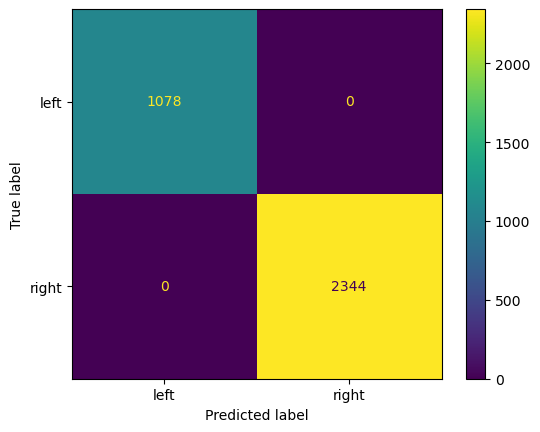

In [59]:
nlm_train_y01_pred = m2v1_gbc.predict(nlm_train_x01_mtx)
nlm_train_y01_pred_cm = confusion_matrix(nlm_train_y01, nlm_train_y01_pred)

print(classification_report(nlm_train_y01, nlm_train_y01_pred))
print(nlm_train_y01_pred_cm)

'''Citation:
https://scikit-learn.org/stable/modules/generated
/sklearn.metrics.ConfusionMatrixDisplay.html
#sklearn.metrics.ConfusionMatrixDisplay.plot
'''
nlm_train_cm_dsp = ConfusionMatrixDisplay(confusion_matrix=nlm_train_y01_pred_cm,
                                          display_labels=m2v1_gbc.classes_)
nlm_train_cm_dsp.plot()
plt.show()

#### ROC-AUC Curve

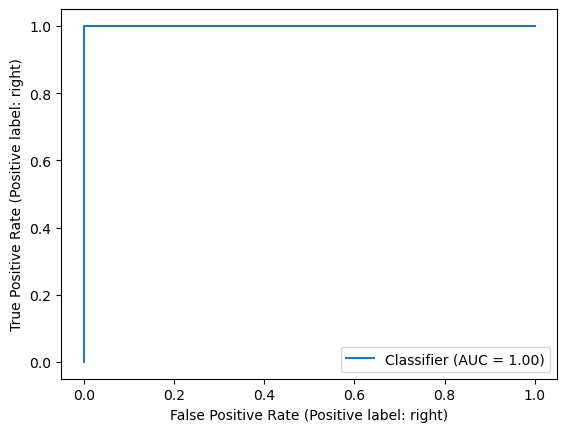

In [60]:
nlm_train_y01_pred_decf = m2v1_gbc.decision_function(nlm_train_x01_mtx)
RocCurveDisplay.from_predictions(nlm_train_y01, nlm_train_y01_pred_decf,
                                 pos_label='right')
plt.show()

#### Test set results

              precision    recall  f1-score   support

        left       0.98      0.88      0.93       190
       right       0.95      0.99      0.97       414

    accuracy                           0.96       604
   macro avg       0.97      0.94      0.95       604
weighted avg       0.96      0.96      0.96       604

[[168  22]
 [  3 411]]


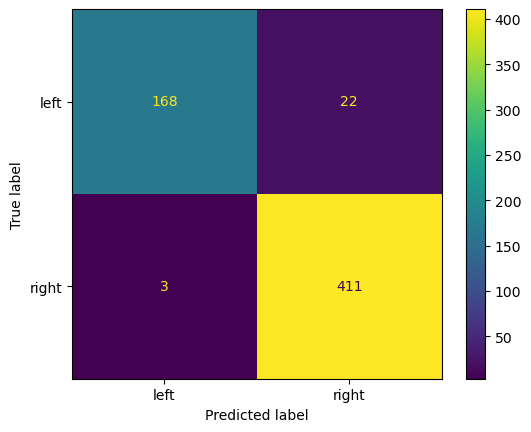

In [61]:
nlm_test_y01_pred = m2v1_gbc.predict(nlm_test_x01_mtx)
nlm_test_y01_pred_cm = confusion_matrix(nlm_test_y01, nlm_test_y01_pred)

print(classification_report(nlm_test_y01, nlm_test_y01_pred))
print(nlm_test_y01_pred_cm)

'''Citation:
https://scikit-learn.org/stable/modules/generated
/sklearn.metrics.ConfusionMatrixDisplay.html
#sklearn.metrics.ConfusionMatrixDisplay.plot
'''
nlm_test_cm_dsp = ConfusionMatrixDisplay(confusion_matrix=nlm_test_y01_pred_cm,
                                         display_labels=m2v1_gbc.classes_)
nlm_test_cm_dsp.plot()
plt.show()

#### Variable importance

In [91]:
print(nlm_train_x01_mtx_cols)
print(type(nlm_train_x01_mtx_cols))
print(nlm_train_x01_mtx_cols.shape)

x = m2v1_gbc.best_estimator_.named_steps['gbc'].feature_importances_
x_df01 = pd.DataFrame(x, columns=['var_imp'])
x_df01['feature'] = nlm_train_x01_mtx_cols
x_df02 = x_df01.sort_values(by=['var_imp'], ascending=False)
x_df03 = x_df02.head(20)

display(x_df02.head())
print(type(x_df02))
print(x_df02.shape)

['03' '04' '05' ... 'zoos' 'zucker' 'zuckerberg']
<class 'numpy.ndarray'>
(49302,)


,var_imp,feature
8855,0.1161,click
34373,0.0185,protecting
43184,0.0178,tex
9344,0.0144,commenting copyright
35239,0.0114,read chart


<class 'pandas.core.frame.DataFrame'>
(49302, 2)


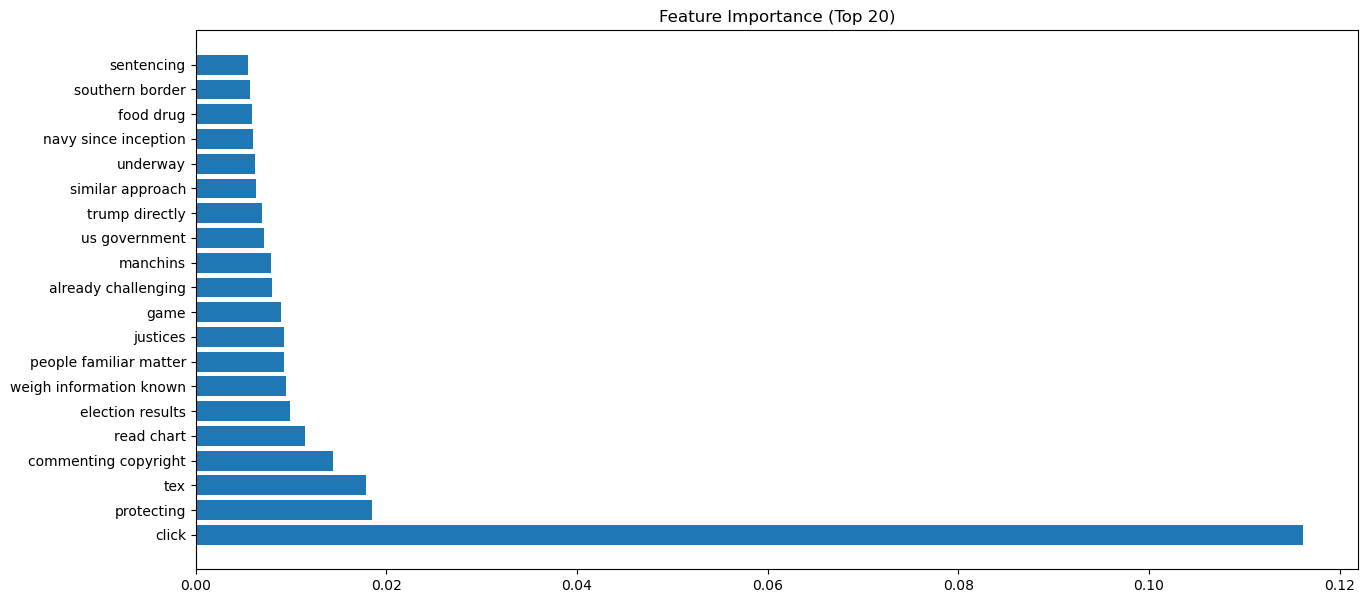

In [102]:
'''Citation:
https://machinelearningmastery.com/calculate-feature-importance-with-python/
'''
# plot feature importance
#figure = plt.figsize((10,9))
plt.figure(figsize=(15,7))
plt.title('Feature Importance (Top 20)')
plt.barh([x for x in range(len(x_df03['var_imp']))], x_df03['var_imp'],
       tick_label=x_df03['feature'])
plt.show()

## Business problem application

In [ ]:
center_df01 = pd.read_csv(file_in_path02)

print(center_df01.shape)
display(center_df01.head())

In [ ]:
# Apply transformers to pandas dataframe, w/ new col containing tokens
center_df01['processed_text'] = center_df01['article_text']\
.progress_apply(prepare, pipeline=transformers01)

center_df01['processed_text_split'] = center_df01['processed_text']\
.progress_apply(str.split)

center_df01['num_tokens'] = center_df01['processed_text_split']\
.map(len)

display(center_df01.head())

# Review unique tokens across entire dataset
for c in range(0,1):
    try:
        print(center_df01['processed_text'][c], '\n')
    except:
        print(f'Skip {c}')

In [ ]:
nlm_apply_x01_mtx = nlm_tfidf.transform(center_df01['processed_text'])

print(nlm_apply_x01_mtx.shape)
display(nlm_apply_x01_mtx)

In [ ]:
display_samp_dwm(sm=nlm_apply_x01_mtx,
                 vec=nlm_tfidf,
                 n=(17,11),
                 rs_tup=(5,1699))

In [ ]:
nlm_apply_mtx_pred_prob = m2v1_gbc.predict_proba(nlm_apply_x01_mtx)

print(nlm_apply_mtx_pred_prob.shape)
print(nlm_apply_mtx_pred_prob[:10])

nlm_apply_mtx_pred = m2v1_gbc.predict(nlm_apply_x01_mtx)

print(nlm_apply_mtx_pred.shape)
print(nlm_apply_mtx_pred)

In [ ]:
# Compute the maximum values along the second dimension
max_values = np.amax(nlm_apply_mtx_pred_prob, axis=1)
max_values_df01 = pd.DataFrame(max_values,
                               columns=['decision_prob'])
max_values_df01['pred'] = nlm_apply_mtx_pred
print(max_values_df01.shape)
display(max_values_df01.head())

In [ ]:
max_values_df01['decision_prob'].plot(kind="hist",
                                      density=True,
                                      alpha=0.5,
                                      legend=True,
                                      figsize=(10,7),
title='''Gradient Boost Model Probability Distribution\n
                                      Applied to Customer Articles''')

In [ ]:
max_values_df01.groupby('pred')['decision_prob'].plot(kind="hist",
                                      density=True,
                                      alpha=0.5,
                                      legend=True,
                                      figsize=(10,7),
                          title='''Gradient Boost Model Probability Distribution
Prediction Confidence''')

In [ ]:
max_values_df02 = pd.DataFrame(nlm_apply_mtx_pred_prob.round(4),
                               columns=['left', 'right'])
max_values_df02['pred'] = nlm_apply_mtx_pred
max_values_df02

In [ ]:
# Plotting histograms
#plt.hist(max_values_df02['left'], bins=10, alpha=0.5, color='blue', label='Column 1')
plt.hist(max_values_df02['right'], bins=10, alpha=0.5, color='red',
         label='right')

# Adding legend and title
plt.legend()
plt.title('Histogram of Right Prediction Probabilities')

# Displaying the plot
plt.show()

In [ ]:
# Plotting histograms
#plt.hist(max_values_df02['left'], bins=10, alpha=0.5, color='blue', label='Column 1')
plt.hist(max_values_df02['left'], bins=10, alpha=0.5, color='blue',
         label='left')

# Adding legend and title
plt.legend()
plt.title('Histogram of Left Prediction Probabilities')

# Displaying the plot
plt.show()

In [ ]:
# Plotting histograms
plt.hist(max_values_df02['left'], bins=10, alpha=0.5, color='blue', label='left')
plt.hist(max_values_df02['right'], bins=10, alpha=0.5, color='red', label='right')

# Adding legend and title
plt.legend()
plt.title('Histogram of Left/Right Prediction Probabilities')

# Displaying the plot
plt.show()